## Magic Eye - Multilabel Image Classification Model
 Problem Description: Build a magic eye to help visually impaired person to Identify objects

In [302]:
## Loading Library modules
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,AveragePooling2D,Dropout,BatchNormalization,Activation,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import time

In [36]:
## Loading Image Dataframe with filename, Class and Image annotations ## Dataset was originally prepared for Object Detection, reusing same for Multilabel Image Classification
df = pd.read_csv("Consolidated-annotations.csv")

In [37]:
## Visualing the loaded dataframe
df.head()

,Unnamed: 0,filename,class,xmin,ymin,xmax,ymax
0,0,image426.jpg,Flowerpot,71,52,153,176
1,1,image426.jpg,Flowerpot,79,41,148,187
2,2,image426.jpg,Flowerpot,154,91,215,174
3,3,image552.jpg,Flowerpot,148,49,346,293
4,4,image76.jpg,Bed,108,328,691,561


In [38]:
## Dropping image annotation as not required for Object classification problem
df.drop(['xmin','xmax','ymin','ymax'], axis=1, inplace=True)

In [39]:
df.head()

,Unnamed: 0,filename,class
0,0,image426.jpg,Flowerpot
1,1,image426.jpg,Flowerpot
2,2,image426.jpg,Flowerpot
3,3,image552.jpg,Flowerpot
4,4,image76.jpg,Bed


In [40]:
## As with Object Detection problem, same image have multiple objects, finding the unique images in dataset
unique_img = df['filename'].unique()

In [41]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2778 entries, 0 to 2777
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2778 non-null   int64 
 1   filename    2778 non-null   object
 2   class       2778 non-null   object
dtypes: int64(1), object(2)
memory usage: 65.2+ KB


In [42]:
## Verifing the Object Classes 
df['class'].unique()  

array(['Flowerpot', 'Bed', 'Table', 'Refrigerator', 'Chair', 'Closet',
       'Stairs', 'Door'], dtype=object)

In [43]:
## 
#class_df = pd.DataFrame(columns=['filename','Flowerpot','Bed', 'Table', 'Refrigerator', 'Chair', 'Closet','Stairs','Door'])

In [44]:
## creating new dataframe, having each row with unique image id and consolidating the multiple labels of image in single record
new_df = pd.DataFrame(columns=['filename', 'labels'])

In [45]:
for i in unique_img:
  temp_df = df[df['filename']==i]
  a = temp_df['class'].unique()
  new_df = new_df.append({'filename': i, 
                        'labels': a},
                         ignore_index=True)

In [46]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660 entries, 0 to 1659
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1660 non-null   object
 1   labels    1660 non-null   object
dtypes: object(2)
memory usage: 26.1+ KB


In [297]:
# Visualizing the new Dataframe
new_df.head(10)

,filename,labels
0,image426.jpg,[Flowerpot]
1,image552.jpg,[Flowerpot]
2,image76.jpg,"[Bed, Table, Flowerpot]"
3,image542.jpg,[Flowerpot]
4,image384.jpg,"[Flowerpot, Table]"
5,image62.jpg,[Refrigerator]
6,image47.jpg,[Flowerpot]
7,image335.jpg,[Chair]
8,image402.jpg,[Refrigerator]
9,image363.jpg,[Closet]


In [47]:
## Splitting Labels 
X = new_df['filename']

In [48]:
Y = new_df['labels']

In [49]:
## Encoding Labels to one-hot encoding 
from sklearn.preprocessing import MultiLabelBinarizer

In [50]:
onehot = MultiLabelBinarizer()

In [51]:
Y = onehot.fit_transform(Y)

In [52]:
Y.shape

(1660, 8)

In [53]:
onehot.classes_

array(['Bed', 'Chair', 'Closet', 'Door', 'Flowerpot', 'Refrigerator',
       'Stairs', 'Table'], dtype=object)

In [54]:
## Train - Test Split
from sklearn.model_selection import train_test_split

In [55]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=10)

In [56]:
## Reseting index of X-train,X-test dataframe ## For ease of batch generatot coding 
X_train.reset_index(inplace=True, drop=True)

In [57]:
X_test.reset_index(inplace=True, drop=True)

In [58]:
## Defining Image Size and Depth
img_size = 224
img_depth = 3

In [298]:
## Batch Generator for train and test set

def batch_generator(data, label, batchsize=64, train_mode=True):   
    
    img_generator= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                   width_shift_range=0.2,
                                                                   height_shift_range=0.2,
                                                                   horizontal_flip=True)
    
    while True:       
        
        
        #Generate random numbers to pick images from dataset
        batch_nums = np.random.randint(0,data.shape[0],batchsize)
        
        #Initialize batch images array
        batch_images = np.zeros((batchsize,img_size, img_size,img_depth))
        
        #Initiate batch label array
        batch_labels = np.zeros((batchsize, 8))
        
        for i in range(batchsize):
            
            #Load image
          object_image =  tf.keras.preprocessing.image.load_img('all_dataset/' + data.loc[batch_nums[i]], target_size=(img_size, img_size))
            #Convert to array
          object_image = tf.keras.preprocessing.image.img_to_array(object_image)
          object_image = (object_image/255)
            
          if(train_mode):
                #Apply transform
               object_image =  img_generator.random_transform(object_image)
            
            
            
            
            #Update batch images and class arrays
          batch_images[i] = object_image
          batch_labels[i] = label[batch_nums[i]]        
        
        yield batch_images, batch_labels          

In [61]:
## Loading ResNet50v2 model with Imagenet weight (using Transfer learning for Feature Extraction, Dropping the Dense layer, output of ResNet model is feeds to Global Average Pool layer)
model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='avg'
)

In [62]:
## Model Summary of ResNet50v2 Model
model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [63]:
## Adding Fully Connected Dense Layers
y = model.output
y = Dense(256, activation='relu')(y)
y = Dropout(0.20)(y)
y = Dense(128, activation='relu')(y)
y = Dropout(0.25)(y)
y = Dense(64, activation='relu')(y)
y = Dropout(0.30)(y)
y = Dense(8, activation='sigmoid')(y)

In [64]:
## Freezing the wieght of ResNetv2 convolutional layers ( Due Limited compute resource to train convolutional layer )
for layer in model.layers:
    layer.trainable = False

In [65]:
new_model = tf.keras.Model(inputs=model.input, outputs=y)

In [66]:
## Compiling model
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [67]:
## Final model Summary
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [68]:
## Referring batch generator to provide random batch of train and test images
batchsize = 64
train_generator = batch_generator(X_train, Y_train, batchsize=batchsize) #batchsize can be changed
test_generator = batch_generator(X_test, Y_test, batchsize=batchsize)

In [69]:
## Checkpoint for save best model
checkpoint_filepath = 'Resnet50'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [70]:
## Model Training
new_model.fit(train_generator,
                        epochs=100,
                        steps_per_epoch= X_train.shape[0]//batchsize,
                        validation_data=test_generator,
                        validation_steps = X_test.shape[0]//batchsize, callbacks=[model_checkpoint_callback]
                       )

In [73]:
## load Best Save model 
load_model = tf.keras.models.load_model("Resnet50")

In [74]:
## Model Summary of Best saved model
load_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [175]:
## Evaluate model on Random Batch generated data on Test Data Set
load_model.evaluate(test_generator, verbose=1, steps = X_test.shape[0]//batchsize)

7/7 [==============================] - 19s 3s/step - loss: 0.5232 - accuracy: 0.7009


[0.5231777429580688, 0.7008928656578064]

In [78]:
## Evaluate model on Random Batch generated Data on train Data set
load_model.evaluate(train_generator, verbose=1, steps = X_train.shape[0]//batchsize)

18/18 [==============================] - 49s 3s/step - loss: 0.0020 - accuracy: 0.9427


[0.0019872530829161406, 0.9427083134651184]

In [251]:
## Function to generator Testing dataset ## Return test image array and one hot encoded label array

def testing(test_size, random=True):
    ## Random test sameple generator
    if random==True:
        rand_test = np.random.randint(0,X_test.shape[0], test_size) 
    else:
        rand_test = np.arange(0,test_size)
    
    ## Image Directory 
    dir = "all_dataset/"
    
    #Initialize batch images array
    test_images = np.zeros((test_size,img_size, img_size,img_depth))
        
    #Initiate batch label array
    true_labels = np.zeros((test_size, 8))
        
    for i in range(test_size):
        ## Loading Image from directory
        test_image = tf.keras.preprocessing.image.load_img(dir + X_test[rand_test[i]], target_size=(img_size, img_size)) 
        
        ## Converting Image to text
        test_image_arr = tf.keras.preprocessing.image.img_to_array(test_image)
        
        ## Scaling Image
        test_image_arr = test_image_arr/255
        
        
        test_images[i] = test_image_arr
        
        true_labels[i] = Y_test[rand_test[i]]
        
    return test_images, true_labels

True_label ('Table',)
Predicted_label [('Table',)]


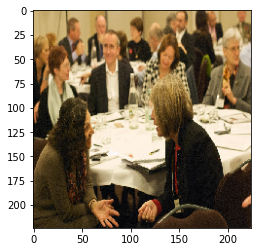

True_label ('Chair', 'Flowerpot', 'Table')
Predicted_label [('Chair', 'Table')]


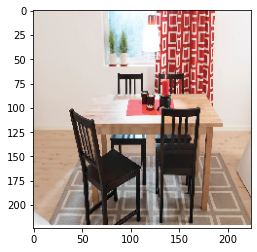

True_label ('Flowerpot',)
Predicted_label [('Flowerpot',)]


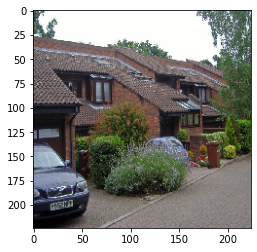

True_label ('Bed',)
Predicted_label [('Bed', 'Flowerpot')]


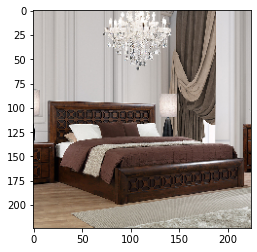

True_label ('Table',)
Predicted_label [('Table',)]


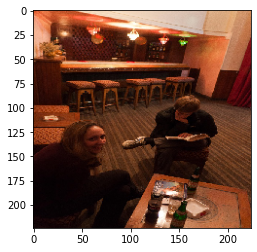

True_label ('Closet',)
Predicted_label [('Closet',)]


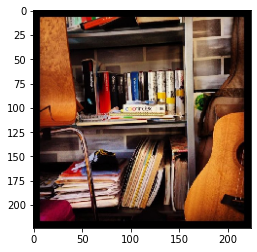

True_label ('Closet',)
Predicted_label [('Closet',)]


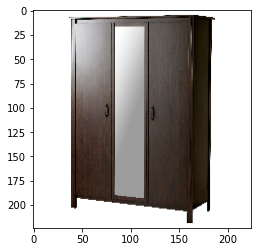

True_label ('Flowerpot', 'Table')
Predicted_label [('Flowerpot', 'Table')]


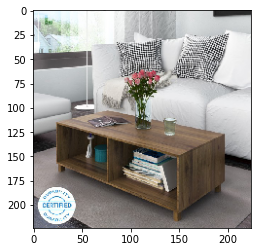

True_label ('Flowerpot',)
Predicted_label [('Chair', 'Table')]


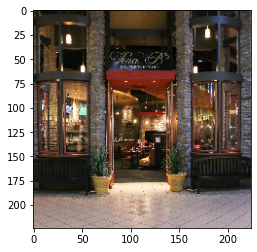

True_label ('Refrigerator',)
Predicted_label [('Refrigerator',)]


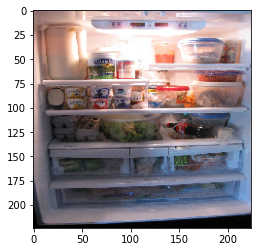

In [237]:
## Visualing Images, True Labels and Predicted Labels
sample = (10)
test_data, true_label = testing(sample)
for i in range(sample):
    print("True_label", onehot.inverse_transform(true_label)[i])
    test_arr = np.expand_dims(test_data[i], axis=0)
    print("Predicted_label", onehot.inverse_transform((load_model.predict(test_arr) > 0.4).astype(int)))
    plt.subplot()
    plt.imshow(test_data[i])
    plt.show()

In [291]:
### Accuracy visualization on completed Dataset
from sklearn.metrics import precision_score, f1_score, classification_report

In [253]:
## Classiy class with Probability score of 0.4 
test_data, true_label = testing(len(X_test), random=False)
Y_predict = (load_model.predict(test_data) > 0.4).astype(int)

In [290]:
print(classification_report(true_label, Y_predict, target_names=img_labels ))

              precision    recall  f1-score   support

         Bed       0.74      0.88      0.81        68
       Chair       0.76      0.60      0.67        85
      Closet       0.72      0.81      0.76        58
        Door       0.76      0.49      0.60        53
   Flowerpot       0.73      0.62      0.67        97
Refrigerator       0.81      0.90      0.85        52
      Stairs       0.77      0.83      0.80        82
       Table       0.73      0.54      0.62        84

   micro avg       0.75      0.70      0.72       579
   macro avg       0.75      0.71      0.72       579
weighted avg       0.75      0.70      0.72       579
 samples avg       0.75      0.73      0.73       579



In [293]:
## Classiy class with Probability score of 0.5
test_data, true_label = testing(len(X_test), random=False)
Y_predict = (load_model.predict(test_data) > 0.5).astype(int)

In [294]:
print(classification_report(true_label, Y_predict, target_names=img_labels ))

              precision    recall  f1-score   support

         Bed       0.77      0.87      0.81        68
       Chair       0.77      0.59      0.67        85
      Closet       0.75      0.81      0.78        58
        Door       0.76      0.49      0.60        53
   Flowerpot       0.74      0.62      0.67        97
Refrigerator       0.84      0.90      0.87        52
      Stairs       0.79      0.82      0.80        82
       Table       0.73      0.51      0.60        84

   micro avg       0.77      0.69      0.73       579
   macro avg       0.77      0.70      0.73       579
weighted avg       0.76      0.69      0.72       579
 samples avg       0.74      0.72      0.72       579



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [296]:
## Classiy class with Probability score of 0.2
test_data, true_label = testing(len(X_test), random=False)
Y_predict = (load_model.predict(test_data) > 0.2).astype(int)
print(classification_report(true_label, Y_predict, target_names=img_labels ))

              precision    recall  f1-score   support

         Bed       0.71      0.88      0.78        68
       Chair       0.72      0.64      0.67        85
      Closet       0.68      0.88      0.77        58
        Door       0.70      0.53      0.60        53
   Flowerpot       0.68      0.67      0.67        97
Refrigerator       0.80      0.90      0.85        52
      Stairs       0.75      0.87      0.80        82
       Table       0.68      0.57      0.62        84

   micro avg       0.71      0.73      0.72       579
   macro avg       0.71      0.74      0.72       579
weighted avg       0.71      0.73      0.72       579
 samples avg       0.75      0.76      0.74       579



In [304]:
## Calculating Prediction time per Image
test_data, true_label = testing(len(X_test), random=False)
start = time.process_time() 
Y_predict = (load_model.predict(test_data) > 0.4).astype(int)
end = time.process_time()

print("Time per image: {} ".format((end-start)/len(test_data)))

Time per image: 0.3621822023393566 


In [86]:
## Plotting the Model
from tkeras.utils.vis_utils import plot_model

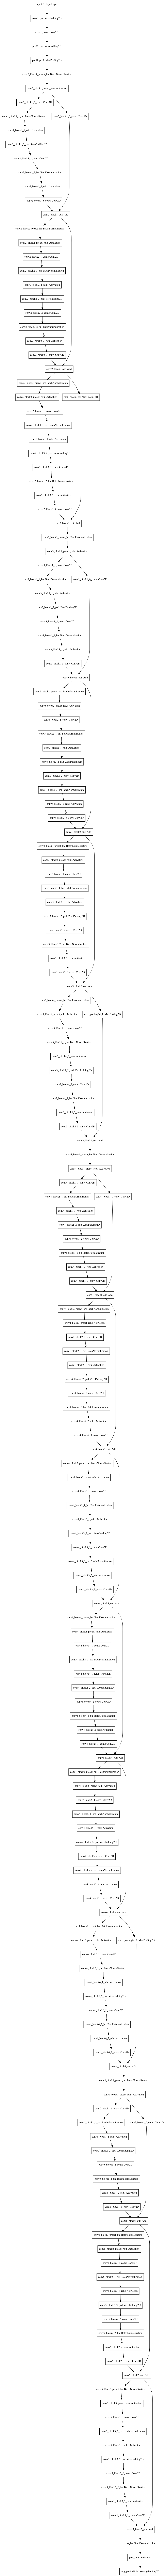

In [90]:
plot_model(model, to_file='Resnet50-10Nov.png')